# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest
from pmdarima.arima import ndiffs


import warnings
warnings.filterwarnings('ignore')

## 5.41 Table B.22 contains data from the Danish Energy Agency on Danish 
crude oil production.
 Develop an appropriate ARIMA model for thi 
data.

In [3]:
# Data for the table
data = {
    'Year': [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
    'Jan': [1372, 1627, 1617, 1560, 1577, 1459, 1266, 1255, 1201, 1095, 987, 826, 787, 675],
    'Feb': [1439, 1457, 1445, 1335, 1536, 1351, 1194, 1024, 1067, 937, 791, 830, 752, 637],
    'Mar': [1499, 1536, 1598, 1626, 1632, 1471, 1290, 1242, 1140, 1014, 964, 854, 808, 691],
    'Apr': [1399, 1560, 1464, 1645, 1605, 1330, 1256, 1101, 1110, 1116, 925, 867, 764, 659],
    'May': [1340, 1575, 1482, 1685, 1568, 1518, 1290, 1275, 1081, 1061, 1090, 866, 756, None],
    'Jun': [1018, 1431, 1514, 1617, 1541, 1377, 1258, 1138, 1066, 906, 872, 860, 682, None],
    'Jul': [1121, 1567, 1406, 1715, 1518, 1547, 1240, 1268, 1112, 1110, 937, 853, 741, None],
    'Aug': [1411, 1267, 1520, 1471, 1591, 1364, 1340, 1141, 1061, 710, 906, 820, 679, None],
    'Sep': [1560, 1421, 1560, 1607, 1459, 1086, 1159, 1085, 1129, 1014, 861, 724, 635, None],
    'Oct': [1492, 1619, 1578, 1726, 1536, 1456, 1382, 1196, 1051, 1080, 859, 824, 720, None],
    'Nov': [1578, 1531, 1574, 1543, 1485, 1429, 1264, 1155, 925, 1009, 930, 819, 687, None],
    'Dec': [1709, 1592, 1550, 1731, 1470, 1450, 1231, 1156, 959, 1106, 818, 838, 671, None]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt into long format
df_long = df.melt(id_vars='Year', var_name='Month', value_name='Production')

# Combine Year and Month into datetime
df_long['Date'] = pd.to_datetime(df_long['Month'] + '-' + df_long['Year'].astype(str), format='%b-%Y')

# Set index and sort
df_long = df_long.set_index('Date').sort_index()

# Drop extra columns
df_final = df_long[['Production']]

# Display
df_final

,Production
Date,
2001-01-01,1372.0
2001-02-01,1439.0
2001-03-01,1499.0
2001-04-01,1399.0
2001-05-01,1340.0
...,...
2014-08-01,NaN
2014-09-01,NaN
2014-10-01,NaN


In [4]:
# Drop the last 8 values
df_final_trimmed = df_final.iloc[:-8]

# Display the result
df_final_trimmed.tail()

,Production
Date,
2013-12-01,671.0
2014-01-01,675.0
2014-02-01,637.0
2014-03-01,691.0
2014-04-01,659.0


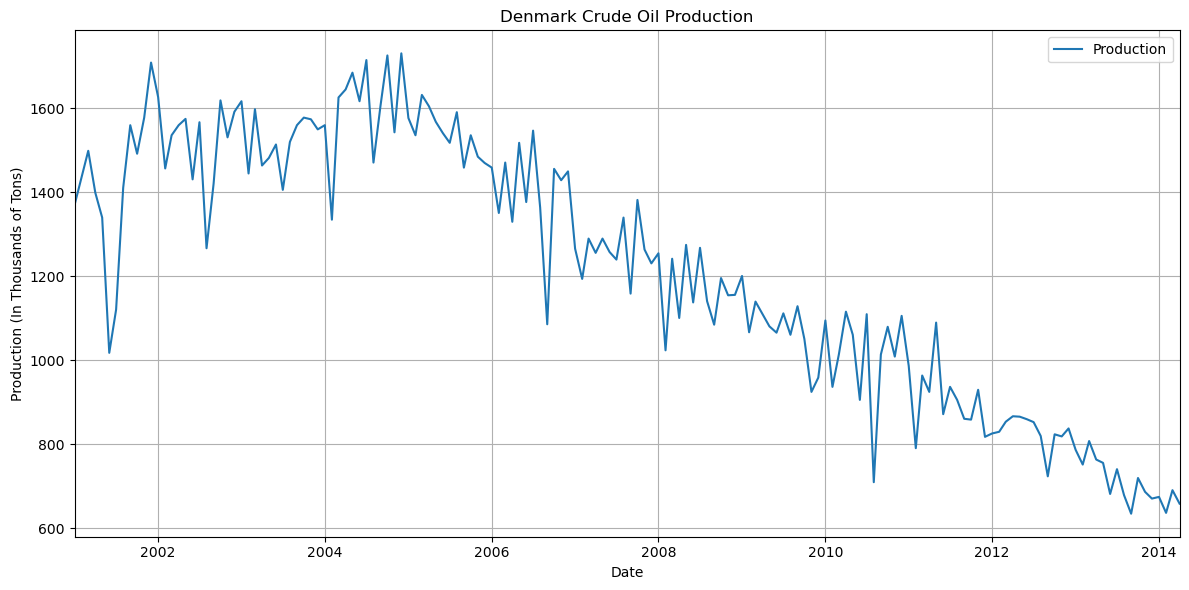

In [5]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_final_trimmed.index, df_final_trimmed['Production'], label='Production')     

plt.title('Denmark Crude Oil Production')                      
plt.xlabel('Date')                                        
plt.ylabel('Production (In Thousands of Tons)')  
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2014-04-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show()

In [6]:
# Split the data
train = df_final_trimmed[df_final_trimmed.index.year < 2012]     # All data before 2012
test = df_final_trimmed[df_final_trimmed.index.year >= 2012]     # All data in 2012

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (132, 1)
Test shape: (28, 1)




(            Production
 Date                  
 2011-08-01       906.0
 2011-09-01       861.0
 2011-10-01       859.0
 2011-11-01       930.0
 2011-12-01       818.0,
 None,
             Production
 Date                  
 2012-01-01       826.0
 2012-02-01       830.0
 2012-03-01       854.0
 2012-04-01       867.0
 2012-05-01       866.0)

In [7]:
production_series = train['Production']

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(production_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.49440636739451144
p-value: 0.9847020870808887

p-value > alpha; H0: Not Stationary


In [9]:
# First-Order differencing
eps_diff = np.diff(production_series, n=1)

ad_fuller_result1 = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -7.897443976429435
p-value: 4.273247454269735e-12

p-value < alpha; Ha: Stationary


    d = 1

In [10]:
from statsmodels.tsa.stattools import adfuller

def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  

d = determine_nonseasonal_d(production_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.4944, p-value = 0.9847
d = 1 | ADF Statistic = -7.8974, p-value = 0.0000

Non-seasonal differencing term (d): 1


In [11]:
from pmdarima.arima import nsdiffs


def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D_ch = nsdiffs(series, m=m, test='ch')
    D_ocsb = nsdiffs(series, m=m, test='ocsb')

    if D_ch == D_ocsb:
        D = D_ch
        return D
    else:
        print(f'CH Test: D = {D_ch}, OCSB Test: D = {D_ocsb}')
        D = D_ch
        return D

D = determine_seasonal_D(production_series, 12)
print(f'Seasonal differencing term (D): {D}')

Seasonal differencing term (D): 0


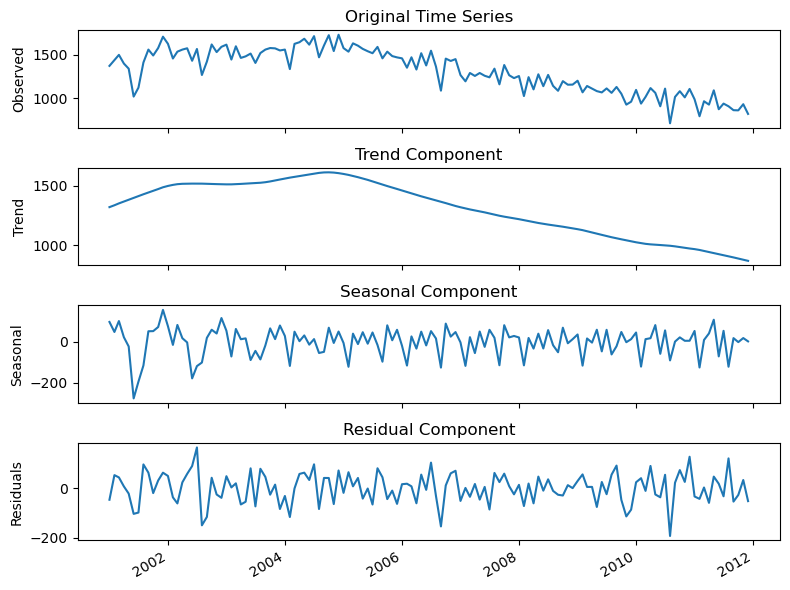

In [12]:
decom_air = STL(production_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [13]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    production_series,          # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=1,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p 
    start_q=0, max_q=3,         # q 
    start_P=0, max_P=3,         # P 
    start_Q=0, max_Q=3,         # Q 
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=False,                # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Print the best model found
print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

Best model: SARIMA(0, 1, 1)(2, 0, 1, 12)


In [14]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2            # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 0
S = 12

total = (P_ns[-1] + 1) * (Q_ns[-1] + 1) * (P_s[-1] + 1) * (Q_s[-1]+ 1)
print(f'Total number of models: {total}')

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(production_series,             # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,0)(3,0,3,12)
Running model #30 using SARIMA(0,1,1)(3,0,2,12)
Running model #45 using SARIMA(0,1,2)(3,0,1,12)
Running model #60 using SARIMA(0,1,3)(3,0,0,12)
Running model #75 using SARIMA(1,1,0)(2,0,3,12)
Running model #90 using SARIMA(1,1,1)(2,0,2,12)
Running model #105 using SARIMA(1,1,2)(2,0,1,12)
Running model #120 using SARIMA(1,1,3)(2,0,0,12)
Running model #135 using SARIMA(2,1,0)(1,0,3,12)
Running model #150 using SARIMA(2,1,1)(1,0,2,12)
Running model #165 using SARIMA(2,1,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,3)(1,0,0,12)
Running model #195 using SARIMA(3,1,0)(0,0,3,12)
Running model #210 using SARIMA(3,1,1)(0,0,2,12)
Running model #225 using SARIMA(3,1,2)(0,0,1,12)
Running model #240 using SARIMA(3,1,3)(0,0,0,12)
Running model #255 using SARIMA(3,1,3)(3,0,3,12)



,index,non-seasonal order,seasonal order,AIC,AICc,model
0,63,"(0, 1, 3)","(3, 0, 3)",1079.513498,1082.263498,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,59,"(0, 1, 3)","(2, 0, 3)",1080.365606,1082.587828,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,123,"(1, 1, 3)","(2, 0, 3)",1081.460664,1084.210664,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,187,"(2, 1, 3)","(2, 0, 3)",1081.593738,1084.93551,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,191,"(2, 1, 3)","(3, 0, 3)",1083.914021,1087.914021,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


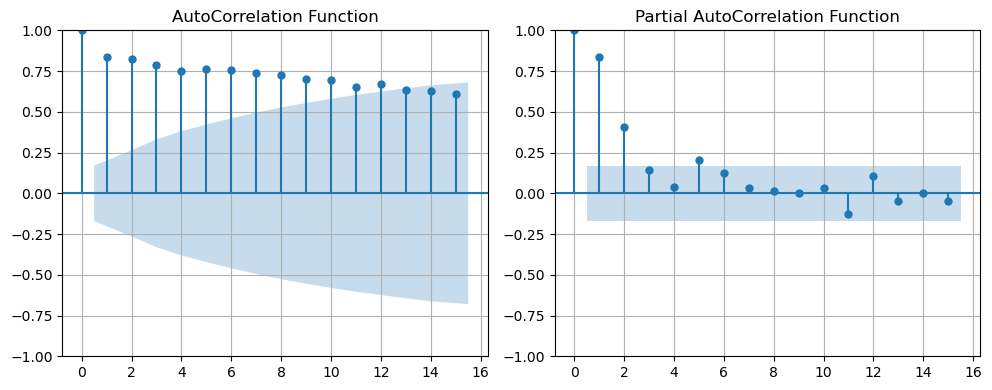

In [15]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(production_series, ax=axes[0], lags=15)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(production_series, ax=axes[1], lags=15)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_013 = SARIMAX(production_series,                   # Time series data
                    order=(0, 1, 3),                     # Non-seasonal order (p,d,q)
                    seasonal_order=(2, 0, 3, 12),        # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)          # Allow non-stationary behavior

# Fit the model
model_fit_013 = model_013.fit()

# Display summary of the model
print(model_fit_013.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Production   No. Observations:                  132
Model:             SARIMAX(0, 1, 3)x(2, 0, 3, 12)   Log Likelihood                -531.183
Date:                            Tue, 08 Apr 2025   AIC                           1080.366
Time:                                    14:05:37   BIC                           1102.963
Sample:                                01-01-2001   HQIC                          1089.482
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7944      0.150     -5.291      0.000      -1.089      -0.500
ma.L2          0.0160      0.169   

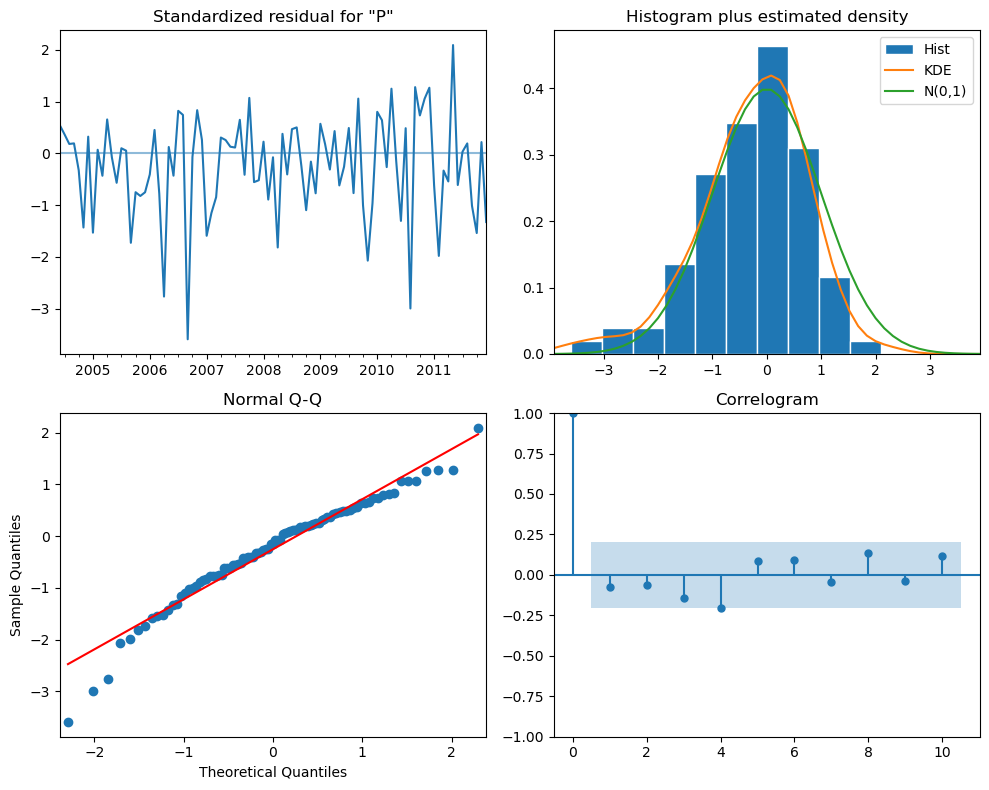

In [17]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_013.resid  

# Diagnostic plots for the model, including residuals and other model checks
model_fit_013.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [18]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.029674,0.863232
2,0.096512,0.952890
3,0.926486,0.819032
4,2.635404,0.620565
5,4.116047,0.532832
6,4.702250,0.582529
7,7.600519,0.369133
8,8.930795,0.348168
9,9.112663,0.426940
10,9.341980,0.499985


In [19]:
# Forecast the next 12 time points
forecast_28m = model_fit_013.get_forecast(steps=28)

# Extract predicted mean and confidence intervals
forecast_mean_28 = forecast_28m.predicted_mean
conf_int_28 = forecast_28m.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast'] = forecast_mean_28.values                                # Forecast mean

test['Error'] = test['Forecast'] - test['Production']

test['Lower 95% CI'] = conf_int_28.iloc[:, 0].values                      # Lower bound
test['Upper 95% CI'] = conf_int_28.iloc[:, 1].values                      # Upper bound

# Show the updated test DataFrame
test

,Production,Forecast,Error,Lower 95% CI,Upper 95% CI
Date,,,,,
2012-01-01,826.0,867.794110,41.794110,720.737864,1014.850356
2012-02-01,830.0,717.369045,-112.630955,567.251037,867.487052
2012-03-01,854.0,861.161937,7.161937,707.571083,1014.752792
2012-04-01,867.0,833.756820,-33.243180,675.283225,992.230415
2012-05-01,866.0,915.566957,49.566957,751.286954,1079.846959
2012-06-01,860.0,805.550249,-54.449751,635.657651,975.442848
2012-07-01,853.0,878.842395,25.842395,703.516157,1054.168633
2012-08-01,820.0,775.372068,-44.627932,594.776034,955.968101
2012-09-01,724.0,765.813393,41.813393,580.097037,951.529749


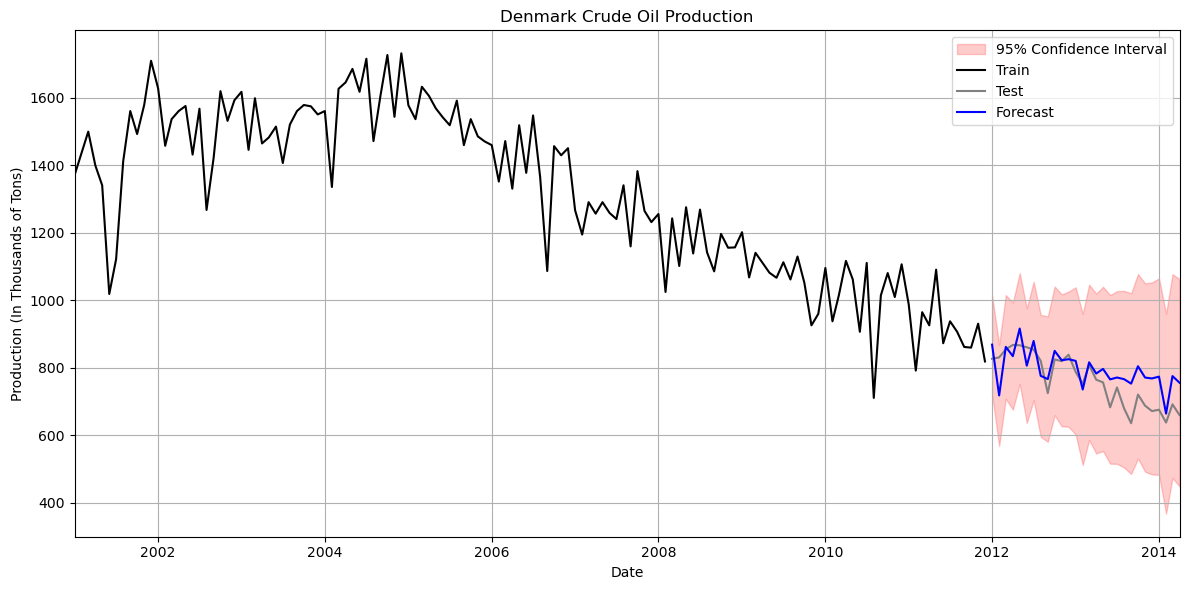

In [20]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_28.iloc[:, 0],     # Lower bound
                 conf_int_28.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['Production'], label='Train', color='black')       # Train
plt.plot(test.index, test['Production'], label='Test', color='gray')           # Test

plt.plot(test.index, test['Forecast'], label='Forecast', color='blue')    # Forecast

plt.title('Denmark Crude Oil Production')                      
plt.xlabel('Date')                                        
plt.ylabel('Production (In Thousands of Tons)')  
plt.xlim(pd.to_datetime('2001-01-01'), pd.to_datetime('2014-04-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [21]:
# Calculate MAPE
mape = (np.abs(test['Error']) / test['Production']).mean() * 100

# Print the result
print(f"MAPE SARIMA(0,1,3)(2,0,3)[12] model: {mape:.2f}%")

MAPE SARIMA(0,1,3)(2,0,3)[12] model: 7.16%


This means that the `SARIMA(0,1,3)(2,0,3)[12]` model has an average prediction error of 7.16% when applied to our test data. In other words, on average, the model's predictions are off by about 7.16% from the actual values (the `Production`).